In [7]:
import torch
import random
import numpy as np
from likelihood import *
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from data_generator import *
from formate_matrix_toMLData import * 
import os
# import openpyxl
from sklearn.model_selection import train_test_split

# from model_scripts.diagonal_var_initial_ratio_02.DeepSets_varSet_diagnal import *
from model_scripts.proto_type.prototype_02.DeepSets_varSet_diagnal import *

import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
np.set_printoptions(suppress=True)
class max_lifespan_loss(nn.Module):
    def forward(self, outputs, targets):
         # 安全のため、小さい値を追加してゼロ割りを防止
        epsilon = 1e-12
        y_pred_inverse = 1.0 / (outputs + epsilon)
        y_true_inverse = 1.0 / (targets + epsilon)
        
        # 逆数の差の絶対値
        loss = torch.abs(y_pred_inverse - y_true_inverse).max()
        
        # 平均損失を計算
        return loss
criterion = max_lifespan_loss()
plt.rcParams["font.size"] = 14  # 全体のフォントサイズ

In [8]:
# #ファイルのロード
# r = 1.1
# df = pd.read_csv("real_data/data_DB2021.csv")
# def categorize_pre_state(row, column):
#     if row[column]>90:
#         return 1
#     elif row[column]>80:
#         return 2
#     elif row[column]>70:
#         return 3
#     else:
#         return 4

# df["pre_state"] = df.apply(categorize_pre_state,axis=1,args = ("BCI1",))
# df["post_state"] = df.apply(categorize_pre_state, axis = 1, args=("BCI2",))
# # display(df)
# df = df.loc[df["Unnamed: 5"] < 10]
# df = df.loc[df["pre_state"] < 4]
# df = df[["pre_state","post_state", "Unnamed: 5"]]
# df.columns = ["pre", "post", "time"]
# plt.hist(df["time"], bins=100)
# display(df)

In [9]:
# # # #国内高速道路床版下面データ
# r =2
# df = pd.read_csv("real_data/shoban.csv",delimiter=",")
# df = df[df["Ins"] < 10]
# df = df[df["Be(1-4)"] != 4]
# df = df[["Be(1-4)","Af(1-4)","Ins"]]
# df.columns = ["pre", "post", "time"]
# display(df)
# # t = {}
# # for ins in df["Ins"]:
# #     if ins in t:
# #         t[ins] +=1
# #     else:
# #         t[ins] = 1
# # t = dict(sorted(t.items()))
# # print(t)
# plt.hist(df["time"],bins = 20, range=(0,11))

In [10]:
# #都市高速道路RC床版
# r = 1.2
# df = pd.read_csv("real_data/Sample.csv", delimiter=",")
# # print(df.columns)
# df = df[["判定2","判定2.1","経過年数"]]
# df = df[df["判定2"]<4]
# df.columns = ["pre", "post","time"]
# plt.hist(df["経過年数"],bins=20)
# plt.xlabel("time")
# plt.ylabel("count")
# i = {}
# j = {}
# for s in df["判定2"]:
#     if s not in i:
#         i[s] = 1
#     else:
#         i[s] += 1
# for s in df["判定2.1"]:
#     if s not in j:
#         j[s] = 1
#     else:
#         j[s] += 1
# print(i)
# print(j)

In [11]:
# #トンネル照明これは使わない
# df = pd.read_csv("real_data/Tunnel.csv",delimiter=",")
# df = df.dropna(subset=["事後健全度"])
# df["事後健全度"] = df["事後健全度"].apply(int)
# df = df[df["検査間隔(年)"]<12]

# df = df[["事前健全度","事後健全度","検査間隔(年)"]]
# df.columns = ["pre", "post", "time"]
# plt.hist(df["time"],bins=20)


In [12]:
#正規化処理

def log_normalize_to_mean_variance(data, target_mean, target_variance):
    # 対数変換
    log_data = np.log(data)
    # 現在の平均と標準偏差
    current_mean = np.mean(log_data)
    current_std = np.std(log_data)
    
    # 標準化 (平均0、分散1)
    standardized_data = (log_data - current_mean) / current_std
    
    # 新しい平均と分散に変換
    new_mean = target_mean
    new_std = np.sqrt(target_variance)
    transformed_data = standardized_data * new_std + new_mean
    log_normal_data = np.exp(transformed_data)
    return log_normal_data, current_mean, current_std, new_mean, new_std

# 逆変換関数
def log_denormalize_to_original(log_normal_data, current_mean, current_std, new_mean, new_std):
    # 対数正規分布の値を対数変換
    transformed_data = np.log(log_normal_data)
    # 標準化を元に戻す
    standardized_data = (transformed_data - new_mean) / new_std
    log_data = standardized_data * current_std + current_mean
    # 指数変換で元のスケールに戻す
    original_data = np.exp(log_data)
    return original_data

# target_mean = 1
# target_variance = 0.5
# df["normalized_t"], current_mean, current_std, new_mean, new_std = log_normalize_to_mean_variance(
#     df["Unnamed: 5"], target_mean, target_variance
# )
# print(current_mean,current_std)
# plt.hist(df["normalized_t"],bins=20, range=(0,10))

In [13]:
# # ガーナ道路
# r = 3.5
# df = pd.read_csv("real_data/Frank.csv",delimiter=",")
# df["time"] = df["Inspection Time of PostState IRI"] - df["Inspection Time of Prestate"]
# df["time sneff"] = df["Inspection Post time for Sneff"] - df["Inspection Time of Prestate"]
# print(df.columns)
# df = df[["Pre-State IRI", "Post-State IRI","time"]]
# post_conditions = [
#     df["Post-State IRI"] <= 1.5,
#     (df["Post-State IRI"] > 1.5) & (df["Post-State IRI"] <= 2.5),
#     (df["Post-State IRI"] > 2.5) & (df["Post-State IRI"] <= 3.5),
#     df["Post-State IRI"] > 3.5
# ]
# pre_conditions = [
#     df["Pre-State IRI"] <= 1.5,
#     (df["Pre-State IRI"] > 1.5) & (df["Pre-State IRI"] <= 2.5),
#     (df["Pre-State IRI"] > 2.5) & (df["Pre-State IRI"] <= 3.5),
#     df["Pre-State IRI"] > 3.5
# ]
# choices = [1,2,3,4]
# df["pre"] = np.select(pre_conditions, choices )
# df["post"] = np.select(post_conditions, choices)
# df = df[["pre","post", "time"]]
# display(df)
# plt.hist(df["time"])
# plt.xlabel("点検間隔（年）")
# plt.ylabel("頻度")
# # plt.title("ガーナの道路舗装の点検間隔の分布")


5360


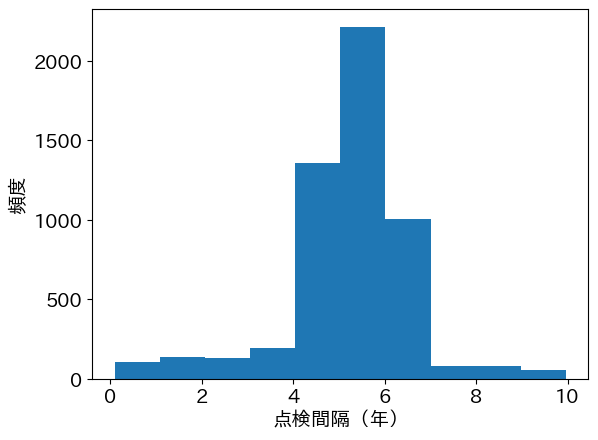

In [14]:
# # #なんかのRC r = 1.79がベスト
r = 1.5
df = pd.read_csv("real_data/data.csv",delimiter=",", header=None)
df.columns = ["pre", "post", "time"]
df = df[df["pre"]<4]
df = df[df["post"] < 5]
# df = df[df["time"] < 3]
# df["normalized"] = log_normalize_to_mean_variance(df["time"],0.42,5)[0]
# df = df[df["normalized"] > 0.1]
df = df[df["time"] > 0.1]
# df["time"] = df["time"]/2.5
plt.hist(df["time"],bins=10)
plt.xlabel("点検間隔（年）")
plt.ylabel("頻度")
# plt.title("橋梁RC床版の点検間隔の分布")
print(len(df))

In [15]:
# # # 水道管 12.3が良さそう
# # r = 12.3
# r = 12

# df = pd.read_csv("real_data/suidou.csv",delimiter=",")
# df = df[["建設時健全度（1と仮定）","調査時健全度","経過年数"]]
# df.columns = ["pre", "post", "time"]
# plt.hist(df["time"],bins=10)
# plt.xlabel("点検間隔（年）")
# plt.ylabel("頻度")
# # plt.title("水道管の点検間隔の分布")
# print(len(df))

In [16]:
state = np.array([df["pre"], df["post"]])
# del_t = np.array(df["normalized"])
del_t = np.array(df["time"]/r)
# del_t2 = np.array(df["Unnamed: 5"])

In [17]:
# print("by 最尤:",expected[9][0]*(10.5+0.1*10))
# print("by AI:",predict[9][0]*(10.5 + 0.1*10))

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(state.T, del_t.T, test_size=0.8, random_state=40)
data = np.column_stack((state.T,del_t.T))
print(data)
ll = Likelihood_diagonal_exp(data)
Q = ll.optimize(np.array([-0.5,-1,-1.5]))
formater = formate_dataMatrix()
vec = formater.GetOutputVector_byDiagonal(Q)

[[2.         2.         3.43744292]
 [2.         2.         3.20547945]
 [2.         2.         3.34611872]
 ...
 [1.         1.         0.47853881]
 [1.         1.         2.39452055]
 [1.         1.         0.87671233]]


In [19]:
d = {}
e = {}
for l in data:
    if l[0] not in d:
        d[l[0]] = 1
    else:
        d[l[0]] += 1

for l in data:
    if l[1] not in e:
        e[l[1]] = 1
    else:
        e[l[1]] += 1
print(dict(sorted(d.items())))
print(dict(sorted(e.items())))

{1.0: 2593, 2.0: 2653, 3.0: 114}
{1.0: 1637, 2.0: 3319, 3.0: 372, 4.0: 32}


In [20]:
print(Q)

[[-0.13021993  0.13021993  0.          0.        ]
 [ 0.         -0.02727598  0.02727598  0.        ]
 [ 0.          0.         -0.04016481  0.04016481]
 [ 0.          0.          0.          0.        ]]


In [21]:
dataset = varSets_Datasets([state],[del_t], [vec])
dataloader = DataLoader(dataset, batch_size=1,shuffle=False,collate_fn=collate_fn)


In [22]:
class max_lifespan_loss(nn.Module):
    def forward(self, outputs, targets):
         # 安全のため、小さい値を追加してゼロ割りを防止
        epsilon = 1e-12
        y_pred_inverse = 1.0 / (outputs + epsilon)
        y_true_inverse = 1.0 / (targets + epsilon)
        
        # 逆数の差の絶対値
        loss = torch.abs(y_pred_inverse - y_true_inverse).max()
        
        # 平均損失を計算
        return loss
criterion = max_lifespan_loss()

In [23]:
model = torch.load("model_scripts\proto_type\prototype_02\diagonal_prototype_02_BigDataSet02.pth",weights_only=False)
model.eval()
pred = []
expect = []
for a, b, c,d in dataloader:
    with torch.no_grad():
        out = model(a, b, d)
        loss = criterion(out,c).item()
        pred = 1/out
        expect = 1/c    
    print(f"output is {out}")
    print(f"target is {c}")
    print(loss)


output is tensor([[0.1487, 0.0317, 0.0269]])
target is tensor([[0.1302, 0.0273, 0.0402]])
12.316019058227539


In [24]:
print(pred*r,expect*r)

tensor([[10.0905, 47.3609, 55.8202]]) tensor([[11.5190, 54.9935, 37.3461]])


代理モデルによる劣化推移予測


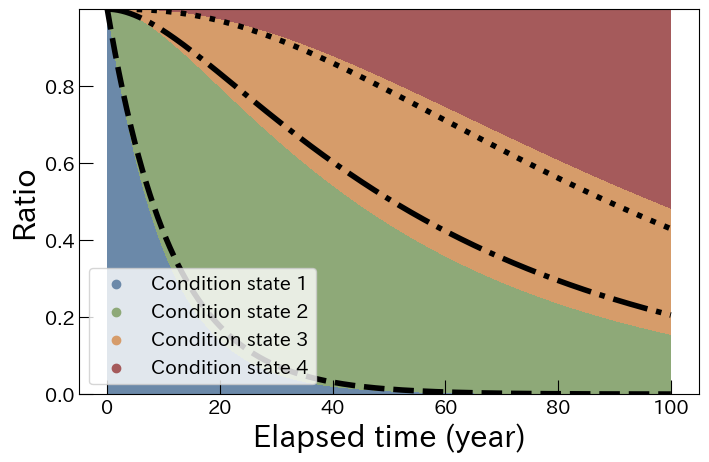

---------------------------


In [25]:
from scipy.linalg import expm
# colors = ['blue', 'yellow', 'purple', 'red']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261']  #落ち着いた感じ
# colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a'] #見やすいやつ
colors = ['#4e79a7', '#f4d03f', '#e67e22', '#c0392b'] #順序
colors = ['#4e79a7', '#76b041', '#e67e22', '#c0392b'] #冷暖色
colors= ['#6b89a9', '#8ea978', '#d69c6a', '#a55a5b'] #彩度下げ冷暖色
# colors= ['#add8e6', '#ffeb3b', '#ff9800', '#f44336'] #グラデーション
plt.rcParams["figure.figsize"] = (8, 5)

sequence = np.arange(0, 100, 0.01)
def visualize(Q,title):
    vecs = []
    for t in sequence:
        P = expm(Q * t)
        vecs.append(P[0])
    
    for i, vec in enumerate(vecs):
        bottom = 0
        # vec = vec[::-1]
    
        for j, value in enumerate(vec):
            plt.bar(sequence[i], value, bottom=bottom, color=colors[j],width=0.01)
            bottom += value
    for i in range(len(colors)):
        plt.scatter([],[], color = colors[i],label = f"Condition state {i+1}")
    vecs = np.array(vecs)
    
    plot_trueline(c[0])
    plt.tick_params(axis='x', labelsize=14, direction='in', length=10)
    plt.tick_params(axis='y', labelsize=14, direction='in', length=10)
    plt.xlabel("Elapsed time (year)", fontsize = 22)
    plt.ylabel("Ratio", fontsize = 22)
    # plt.title(title, fontsize = 18)
    plt.legend(loc = "lower left")
    plt.show()
    
def generate_Q_from_diagonal(vec):
        Q = np.zeros((4,4))
        for i in range(len(vec)):
            Q[i,i+1]= vec[i]
            Q[i,i] = -Q[i,i+1]
        return Q
def plot_trueline(vec):
    true_vecs = []
    true_Q = generate_Q_from_diagonal(vec/r)
    for t in sequence:
        P = expm(true_Q * t)
        true_vecs.append(P[0])
    true_vecs = np.array(true_vecs)
    
    plt.plot(sequence,true_vecs[:,0],linestyle = "--",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1],linestyle = "-.",color = "black",lw = 4)
    plt.plot(sequence,true_vecs[:,0]+true_vecs[:,1]+true_vecs[:,2],linestyle = ":",color = "black",lw = 4)
    

print("代理モデルによる劣化推移予測")
visualize(generate_Q_from_diagonal(out[0]/r),"代理モデルによる劣化推移予測")
print("---------------------------")
# print("最尤推定による劣化推移予測")
# visualize(generate_Q_from_diagonal(c[0]/r), "最尤推定による劣化推移予測")